### Постановка задачи
Построить простую модель энергопотребления здания по среднему значению, 
оценить эффективность модели через метрику
\begin{equation}
RMSLE = {\sqrt{\sum_{i=1}^{n}{(log(p_i+1) - log(a_i+1))^2} \over n}}.
\end{equation}
* n - число наблюдений
* log - натуральный логарифм
* p_i - вычисленное значение метрики
* a_i - заданное значение метрики

Данные: http://video.ittensive.com/machine-learning/ashrae/train.0.0.csv.gz
Соревнование: https://www.kaggle.com/c/ashrae-energy-prediction/

© ITtensive, 2020

### Загрузка библиотек

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 8

### Загрузка данных
Дополнительно сразу отсечем пустые дни и выделим час из значения времени

In [5]:
energy_0 = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.0.csv.gz")
energy_0 = energy_0[energy_0["meter_reading"] > 0]
energy_0["timestamp"] = pd.to_datetime(energy_0["timestamp"])
energy_0["hour"] = energy_0["timestamp"].dt.hour
print (energy_0.head())

      building_id  meter           timestamp  meter_reading  hour
704             0      0 2016-01-30 08:00:00        43.6839     8
725             0      0 2016-01-31 05:00:00        37.5408     5
737             0      0 2016-01-31 17:00:00        52.5571    17
2366            0      0 2016-04-08 14:00:00        59.3827    14
2923            0      0 2016-05-01 19:00:00       448.0000    19


### Разделение данных на обучение и проверку
Выделим 20% всех данных на проверку, остальные оставим на обучение

In [6]:
energy_0_train, energy_0_test = train_test_split(energy_0, test_size=0.2)
print (energy_0_train.head())

      building_id  meter           timestamp  meter_reading  hour
6652            0      0 2016-10-04 04:00:00        246.404     4
7000            0      0 2016-10-18 16:00:00        250.500    16
6381            0      0 2016-09-22 21:00:00        236.848    21
3388            0      0 2016-05-21 04:00:00        244.357     4
3716            0      0 2016-06-03 20:00:00        241.626    20


### Создадим модели
Среднее и медианное значение потребление энергии по часам

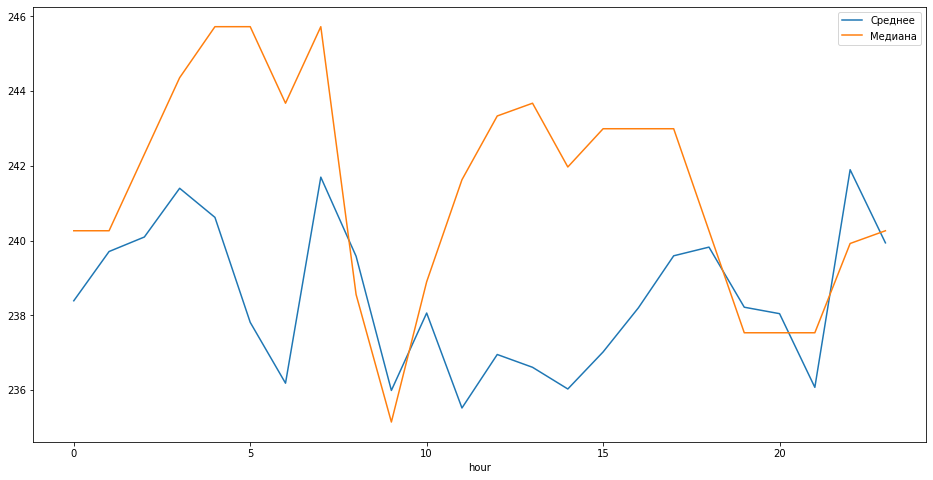

         Среднее   Медиана
hour                      
0     238.386941  240.2610
1     239.705069  240.2610
2     240.093510  242.3090
3     241.397588  244.3570
4     240.619106  245.7220
5     237.809482  245.7220
6     236.181393  243.6740
7     241.695728  245.7220
8     239.578647  238.5550
9     235.987770  235.1420
10    238.058918  238.8960
11    235.518184  241.6260
12    236.949274  243.3325
13    236.606841  243.6740
14    236.026277  241.9675
15    237.018138  242.9910
16    238.198615  242.9910
17    239.590452  242.9910
18    239.822959  240.2610
19    238.214811  237.5310
20    238.041979  237.5310
21    236.070452  237.5310
22    241.894508  239.9200
23    239.937476  240.2610


In [8]:
energy_0_train_hours = energy_0_train.groupby("hour")
energy_0_train_averages = pd.DataFrame(
    {"Среднее": energy_0_train_hours.mean()["meter_reading"],
     "Медиана": energy_0_train_hours.median()["meter_reading"]})
energy_0_train_averages.plot()
plt.show()
print (energy_0_train_averages)

### Функция проверки модели
\begin{equation}
RMSLE = {\sqrt{\sum_{i=1}^{n}{(log(p_i+1) - log(a_i+1))^2} \over n}}.
\end{equation}

Для вычисления метрики создадим шесть новых столбцов в тестовом наборе данных: с логарифмом значения метрики, предсказанием по среднему и по медиане, а также с квадратом разницы предсказаний и логарифма значения. Последний столбец добавим, чтобы сравнить предсказание с его отсутствием - нулями в значениях.

In [17]:
def calculate_model (x):
    meter_reading_log = np.log(x.meter_reading + 1)
    meter_reading_mean = np.log(energy_0_train_averages["Среднее"][x.hour] + 1)
    meter_reading_median = np.log(energy_0_train_averages["Медиана"][x.hour] + 1)
    x["meter_reading_mean_q"] = (meter_reading_log - meter_reading_mean)**2
    x["meter_reading_median_q"] = (meter_reading_log - meter_reading_median)**2
    x["meter_reading_zero_q"] = (meter_reading_log)**2
    return x

energy_0_test = energy_0_test.apply(calculate_model,
                                    axis=1, result_type="expand")
print (energy_0_test.head())

      building_id  meter           timestamp  meter_reading  hour  \
8231            0      0 2016-12-08 23:00:00        71.6688    23   
8021            0      0 2016-11-30 05:00:00       214.3240     5   
4742            0      0 2016-07-16 14:00:00       297.5960    14   
3637            0      0 2016-05-31 13:00:00       183.6090    13   
5816            0      0 2016-08-30 08:00:00       246.4040     8   

      meter_reading_mean_q  meter_reading_median_q  meter_reading_zero_q  
8231              1.436703                1.439921             18.369043  
8021              0.010717                0.018528             28.859930  
4742              0.053324                0.042504             32.479644  
3637              0.063694                0.079347             27.230029  
5816              0.000783                0.001039             30.371370  


Теперь остается просуммировать квадраты расхождений, разделить на количество значений и извлечь квадратный корень

In [20]:

energy_0_test_median_rmsle = np.sqrt(energy_0_test["meter_reading_median_q"].sum() / len(energy_0_test))
energy_0_test_mean_rmsle = np.sqrt(energy_0_test["meter_reading_mean_q"].sum() / len(energy_0_test))
energy_0_test_zero_rmsle = np.sqrt(energy_0_test["meter_reading_zero_q"].sum() / len(energy_0_test))
print ("Качество медианы:", energy_0_test_median_rmsle)
print ("Качество среднего:", energy_0_test_mean_rmsle)
print ("Качество нуля:", energy_0_test_zero_rmsle)

Качество медианы: 0.26511879178888437
Качество среднего: 0.262712762033279
Качество нуля: 5.441096596283522
